# AutoML Classification

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

This is a copy of the test set of the **UCI ML hand-written digits datasets** http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where each class refers to a digit.



<img src="https://www.seewald.at/img/L/digits.gif">


## Documentation Azure ML service
> https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-automated-ml

## 1. Informations

As part of the setup you have already created an Azure ML `Workspace` object. <br> For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [2]:
import azureml.core
print("Version Azure ML Service :", azureml.core.VERSION)

Version Azure ML Service : 1.4.0


In [3]:
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

## 2. Connexion workspace Azure ML service

In [4]:
ws = Workspace.from_config()

experiment_name = 'Exemple2-automlclassificationSR'

project_folder = './sample_projects/workshop2'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

,
SDK version,1.4.0
Workspace Name,workshopAML2020
Resource Group,workshopAML2020-rg
Location,westeurope
Project Directory,./sample_projects/workshop2
Experiment Name,Exemple2-automlclassificationSR


In [5]:
from azureml.core import ComputeTarget, Datastore, Dataset

print("Compute Targets :")
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print("\t", compute.name, ':', compute.type)
    
print("Datastores :")
for datastore_name in ws.datastores:
    datastore = Datastore.get(ws, datastore_name)
    print("\t", datastore.name, ':', datastore.datastore_type)
    
print("Datasets :")
for dataset_name in list(ws.datasets.keys()):
    dataset = Dataset.get_by_name(ws, dataset_name)
    print("\t", dataset.name)

Compute Targets :
	 drift-aks : AKS
	 instanceds3v2 : ComputeInstance
Datastores :
	 azureml : AzureBlob
	 modelservingdata : AzureBlob
	 aiexportdata : AzureBlob
	 modeldata : AzureBlob
	 teststorageserge : AzureBlob
	 azureml_globaldatasets : AzureBlob
	 workspaceblobstore : AzureBlob
	 workspacefilestore : AzureFile
Datasets :
	 drift-demo-dataset
	 target
	 dataset
	 Iris
	 mnist dataset
	 diabetes dataset


## 3. Chargement des données

This uses scikit-learn's [load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) method.

Each datapoint is a 8x8 image of a digit.

In [6]:
from sklearn import datasets

digits = datasets.load_digits()

# Exclude the first 100 rows from training so that they can be used for test.
X_train = digits.data[100:,:]
y_train = digits.target[100:]

In [7]:
print("Taille du dataset : ", digits.data.shape)

Taille du dataset :  (1797, 64)


> On a 1797 images de 8 sur 8 pixels (=64).

### Exemples d'images :

In [8]:
def visu(chiffre):
    import matplotlib.pyplot as plt 
    plt.gray() 
    plt.matshow(digits.images[chiffre]) 
    plt.show() 

<Figure size 432x288 with 0 Axes>

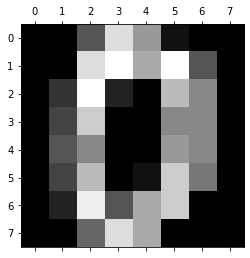

In [12]:
visu(0)

<Figure size 432x288 with 0 Axes>

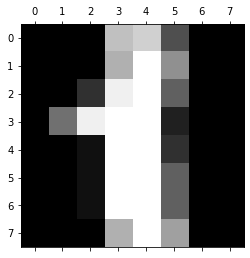

In [13]:
visu(1)

<Figure size 432x288 with 0 Axes>

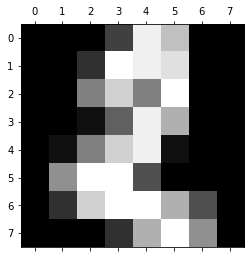

In [14]:
visu(2)

<Figure size 432x288 with 0 Axes>

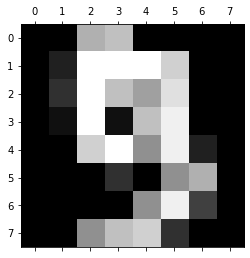

In [15]:
visu(9)

## 4. Configuration AutoML



In [16]:
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl2.log',
                             primary_metric = 'AUC_weighted', #the metric I want to use
                             iteration_timeout_minutes = 2, # Temps max par itération
                             experiment_timeout_minutes = 15, # Temps max pour le process AutoML
                             enable_early_stopping=True, # Sortie si pas d'amélioration de la métrique
                             iterations = 10,           # Possibilité de définir le nombre d'itérations max
                             n_cross_validations = 3,    # Nombre de validations croisées
                             verbosity = logging.INFO,
                             X = X_train, 
                             y = y_train)

WARNING - The AutoMLConfig inputs you have specified will soon be deprecated. Please use the AutoMLConfig shown in our documentation: https://aka.ms/AutoMLConfig


## 5. AutoML

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

`AUC_weighted` is the **metric** used.

In [17]:
#Mise à jour si besoin (redémarrer le kernel ensuite)
#!pip install --upgrade azureml-sdk[automl]

In [18]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_46b26951-e812-4493-870d-51d021e9cd02

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in

In [19]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
Exemple2-automlclassificationSR,AutoML_46b26951-e812-4493-870d-51d021e9cd02,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


## 6. Exploration des résultats AutoML

### 6.1 Notebook Widget


In [20]:
from azureml.widgets import RunDetails
RunDetails(local_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…


### 6.2 Métriques par itération


In [21]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
AUC_macro,1.00,1.00,0.99,1.00,1.00,1.00,0.99,1.00,1.00,0.98
AUC_micro,1.00,1.00,0.99,1.00,1.00,1.00,0.99,1.00,1.00,0.97
AUC_weighted,1.00,1.00,0.99,1.00,1.00,1.00,0.99,1.00,1.00,0.98
accuracy,0.96,0.96,0.95,0.96,0.94,0.95,0.91,0.95,0.97,0.80
average_precision_score_macro,0.99,0.99,0.98,0.99,0.98,0.98,0.94,0.98,1.00,0.93
average_precision_score_micro,0.99,0.99,0.98,0.99,0.98,0.99,0.94,0.98,1.00,0.89
average_precision_score_weighted,0.99,0.99,0.98,0.99,0.98,0.98,0.94,0.98,1.00,0.93
balanced_accuracy,0.96,0.96,0.95,0.96,0.94,0.95,0.91,0.95,0.97,0.81
f1_score_macro,0.96,0.96,0.95,0.96,0.94,0.95,0.91,0.95,0.97,0.78
f1_score_micro,0.96,0.96,0.95,0.96,0.94,0.95,0.91,0.95,0.97,0.80


## 7. Récupération du meilleur modèle

In [22]:
best_run, fitted_model = local_run.get_output()
print(best_run)

Run(Experiment: Exemple2-automlclassificationSR,
Id: AutoML_46b26951-e812-4493-870d-51d021e9cd02_8,
Type: None,
Status: Completed)


In [23]:
print(fitted_model)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...        tol=0.001))]))],
               flatten_transform=None, weights=[0.4, 0.3, 0.1, 0.1, 0.1]))])


In [24]:
fitted_model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...        tol=0.001))]))],
               flatten_transform=None, weights=[0.4, 0.3, 0.1, 0.1, 0.1]))])>

In [25]:
fitted_model.steps

[('datatransformer',
  DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
          feature_sweeping_config=None, feature_sweeping_timeout=None,
          featurization_config=None, force_text_dnn=None,
          is_cross_validation=None, is_onnx_compatible=None, logger=None,
          observer=None, task=None, working_dir=None)),
 ('prefittedsoftvotingclassifier',
  PreFittedSoftVotingClassifier(classification_labels=None,
                 estimators=[('0', Pipeline(memory=None,
       steps=[('maxabsscaler', MaxAbsScaler(copy=True)), ('lightgbmclassifier', LightGBMClassifier(boosting_type='gbdt', class_weight=None,
            colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
            max_depth=-1, min_child_samples=20, ...           penalty='none', power_t=0.4444444444444444, random_state=None,
             tol=0.001))]))],
                 flatten_transform=None, weights=[0.4, 0.3, 0.1, 0.1, 0.1]))]

In [26]:
print("Métriques du meilleur modèle :")
print()
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print('-', metric_name, '=', metric)

Métriques du meilleur modèle :

- confusion_matrix = aml://artifactId/ExperimentRun/dcid.AutoML_46b26951-e812-4493-870d-51d021e9cd02_8/confusion_matrix
- average_precision_score_micro = 0.9951084836699758
- AUC_weighted = 0.9993169930532767
- balanced_accuracy = 0.9661348560538404
- average_precision_score_macro = 0.9953043822994315
- f1_score_micro = 0.9658275743456644
- weighted_accuracy = 0.9654283080199222
- accuracy_table = aml://artifactId/ExperimentRun/dcid.AutoML_46b26951-e812-4493-870d-51d021e9cd02_8/accuracy_table
- precision_score_weighted = 0.9670516324786206
- AUC_macro = 0.9993334674089979
- f1_score_macro = 0.9659387981508921
- log_loss = 0.16723299185173165
- recall_score_macro = 0.9661348560538404
- recall_score_weighted = 0.9658275743456644
- f1_score_weighted = 0.9659570031856454
- accuracy = 0.9658275743456644
- precision_score_macro = 0.9667019813561587
- recall_score_micro = 0.9658275743456644
- AUC_micro = 0.9993068944726357
- precision_score_micro = 0.9658275743

### 7.1 Changement de la métrique AutoML


In [27]:
lookup_metric = "f1_score_weighted"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print("Meilleur modèle :")
print()
print('Best Run =', best_run)
print()
print(fitted_model)

Meilleur modèle :

Best Run = Run(Experiment: Exemple2-automlclassificationSR,
Id: AutoML_46b26951-e812-4493-870d-51d021e9cd02_8,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...        tol=0.001))]))],
               flatten_transform=None, weights=[0.4, 0.3, 0.1, 0.1, 0.1]))])


Choix d'une itération particulière :

In [28]:
iteration = 2

my_run, my_model = local_run.get_output(iteration = iteration)
print("Modèle",iteration,"eme itération :")
print(my_run)
print()
print(my_model)

Modèle 2 eme itération :
Run(Experiment: Exemple2-automlclassificationSR,
Id: AutoML_46b26951-e812-4493-870d-51d021e9cd02_2,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...    n_jobs=1, penalty='none', power_t=0.1111111111111111,
           random_state=None, tol=0.001))])


## 8. Application du modèle

### 8.1 Chargement des données

In [29]:
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

### 8.2 Test
We will try to predict 2 digits and see how our model works.

4


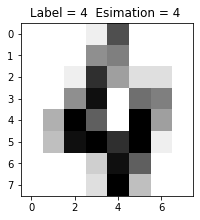

0


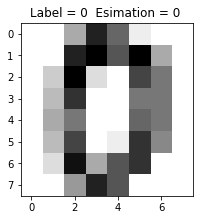

CPU times: user 401 ms, sys: 17.1 ms, total: 418 ms
Wall time: 403 ms


In [30]:
%%time
# Randomly select digits and test.
for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = "Label = %d  Esimation = %d " % (label, predicted)
    fig = plt.figure(1, figsize = (3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()

## 9. Référencement du modèle

### Meilleur modèle

In [31]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print()
print(fitted_model)
print()
print("Métriques :")
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, '=', metric)

Run(Experiment: Exemple2-automlclassificationSR,
Id: AutoML_46b26951-e812-4493-870d-51d021e9cd02_8,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...        tol=0.001))]))],
               flatten_transform=None, weights=[0.4, 0.3, 0.1, 0.1, 0.1]))])

Métriques :
confusion_matrix = aml://artifactId/ExperimentRun/dcid.AutoML_46b26951-e812-4493-870d-51d021e9cd02_8/confusion_matrix
average_precision_score_micro = 0.9951084836699758
AUC_weighted = 0.9993169930532767
balanced_accuracy = 0.9661348560538404
average_precision_score_macro = 0.9953043822994315
f1_score_micro = 0.9658275743456644
weighted_accuracy = 0.9654283080199222
accuracy_table = aml://artifactId/ExperimentRun/dcid.Au

In [32]:
for step in fitted_model.named_steps:
    print(step)

datatransformer
prefittedsoftvotingclassifier


### Référencement du modèle

In [33]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', model_name='mybestmodel',
                        tags={'Training context':'Azure Auto ML'},
                        properties={'AUC': best_run_metrics['AUC_weighted'], 'Accuracy': best_run_metrics['accuracy']})

Model(workspace=Workspace.create(name='workshopAML2020', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='workshopAML2020-rg'), name=mybestmodel, id=mybestmodel:7, version=7, tags={'Training context': 'Azure Auto ML'}, properties={'AUC': '0.9993169930532767', 'Accuracy': '0.9658275743456644'})

In [34]:
# Liste des modèles référencés
for model in Model.list(ws):
    print(model.name, '- version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

mybestmodel - version = 7
	 Training context : Azure Auto ML
	 AUC : 0.9993169930532767
	 Accuracy : 0.9658275743456644


RegressionRidge - version = 8
	 area : Diabetes
	 type : Regression Ridge
	 k : 0.4
	 MSE : 3295.741064355809
	 R2 : 0.3572956390661659
	 Framework : Azure ML


IBM_attrition_explainer - version = 11


local_deploy_model - version = 11


boston_model.pkl - version = 15
	 algo : Regression
	 Training context : Azure ML
	 Framework : scikit-learn


Exemple10-Modele-TensorFlow - version = 17
	 Framework : TensorFlow
	 Hyperdrive : Oui
	 GPU : Oui


diabetes_model - version = 16
	 Training context : Pipeline


Modele-SKLEARN-Regression - version = 3
	 area : diabetes
	 type : regression
	 format : Scikit-Learn pkl


mybestmodel - version = 6
	 Training context : Azure Auto ML
	 AUC : 0.9993067801973444
	 Accuracy : 0.962881891241127


boston_model.pkl - version = 14
	 algo : Regression
	 Training context : Azure ML
	 Framework : scikit-learn


Exemple3-AutoML-Regression

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">